<center><h1>Enhao_Wang_Final_Project_Code & Plots</h1></center>

In [9]:
# import all the needed packages.
import pandas as pd
import numpy as np
import folium
from IPython.display import display,HTML
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import statsmodels.api as sm
from scipy import stats
from shapely.geometry import Point
from shapely.geometry import LineString

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR,SVC
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures,normalize
from sklearn.model_selection import train_test_split,cross_val_score

## 1. Data Cleaning and Combination

Clean the first dataset(house_info.csv).

In [10]:
dataset=pd.read_csv('house_info.csv')
dataset=dataset.drop(['Number of beds'],axis=1)
dataset=dataset[dataset['Price(in $)'] != 'Call for Rent'] # exclude the data with no given price

dataset['Price(in $)']=dataset['Price(in $)'].astype('float')
columns=list(dataset.columns)

# group the data by name and location, to exclude all repetitive data
groups = dataset.groupby(columns[:2])

new_dataset=[]
# Iterate through the groups and print each group
for name, group in groups:
    price=sum(group['Price(in $)'])/group.shape[0] # average the price in each location
    group=pd.DataFrame({columns[0]:[name[0]],columns[1]:[name[1]],columns[2]:[price]})
    new_dataset.append(group)

pd.concat(new_dataset,axis=0).to_csv('house_info_cleaned.csv',index=0) # save as .csv file

Clean the second, third and forth datasets.

In [11]:
for file_name in ['coordinates','distances','crime_count']:
    dataset=pd.read_csv(file_name+'.csv')
    columns=list(dataset.columns)

    # group the data by name and location, to exclude all repetitive data
    groups = dataset.groupby(columns[:2])

    new_dataset=[]

    for name, group in groups:
        new_dataset.append(group.iloc[-1:]) # only keep the last record in each group, because the data in each group is the same

    pd.concat(new_dataset,axis=0).to_csv(file_name+'_cleaned.csv',index=0) # save as .csv file

Merge the four datasets as a data frame.

In [12]:
datasets=[pd.read_csv('house_info_cleaned.csv'),pd.read_csv('coordinates_cleaned.csv'),pd.read_csv('distances_cleaned.csv'),pd.read_csv('crime_count_cleaned.csv')]

merged_dataset=datasets[0]
for i in range(3):
    merged_dataset=pd.merge(merged_dataset,datasets[i+1],on=['Name','Location'])

Show the box plots of distance and price to see outliers.

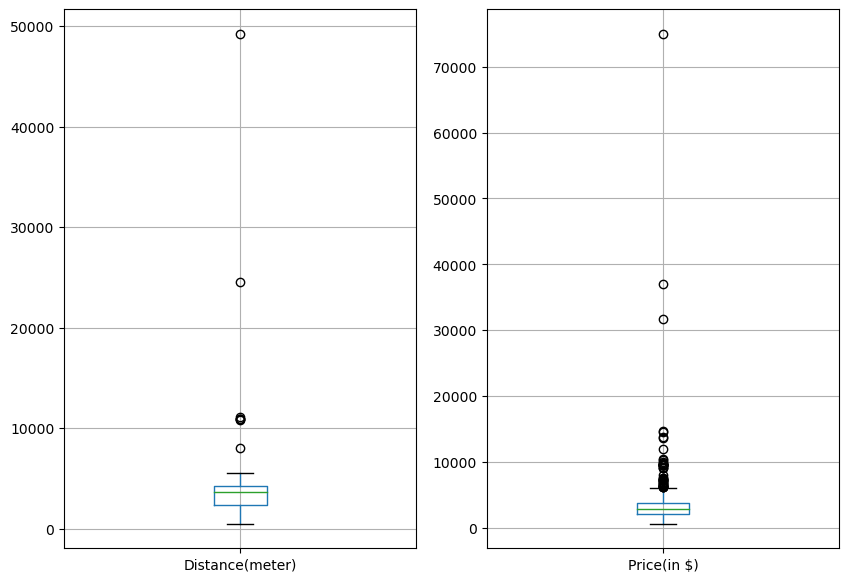

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
merged_dataset.boxplot(column='Distance(meter)')

plt.subplot(1,2,2)
merged_dataset.boxplot(column='Price(in $)')
plt.show()

Show the detailed distribution of distance and price.

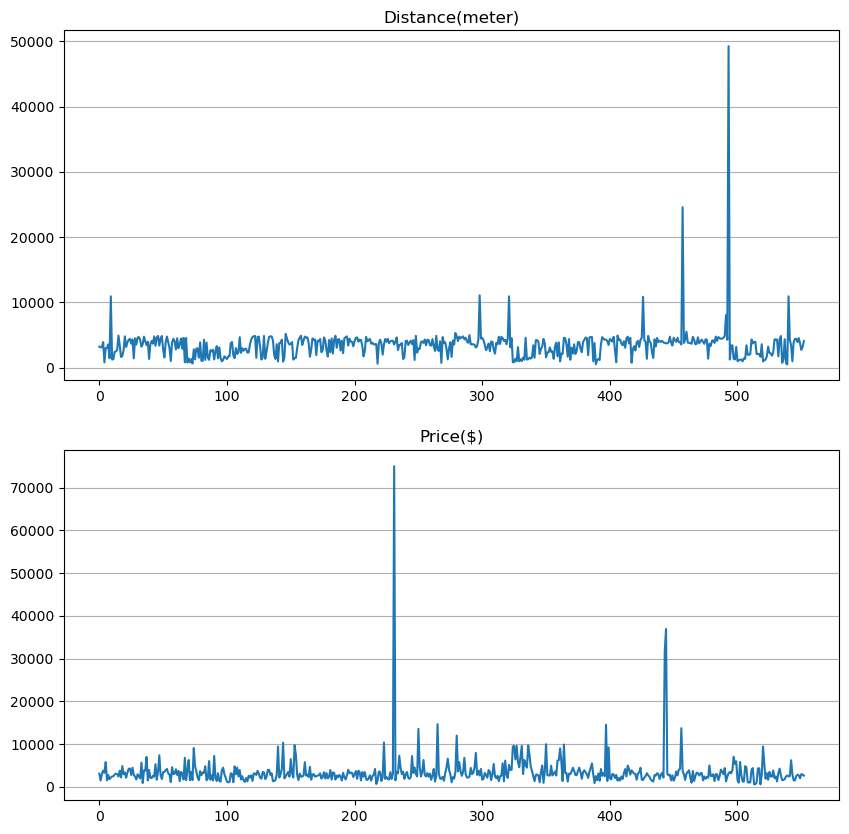

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(merged_dataset['Distance(meter)'])
plt.grid(axis='y')
plt.title('Distance(meter)')

plt.subplot(2,1,2)
plt.plot(merged_dataset['Price(in $)'])
plt.grid(axis='y')
plt.title('Price($)')

plt.show()

Delete the outliers in the data frame and save it as the final data set.

In [15]:
merged_dataset=merged_dataset[merged_dataset['Distance(meter)'] <= 6000] # exclude the outlier of distance
merged_dataset=merged_dataset[merged_dataset['Price(in $)'] <= 20000] # exclude the outlier of price
for column in merged_dataset.columns[6:]:
    merged_dataset[column]=merged_dataset[column].astype(int)
    if sum(merged_dataset[column])==0:
        merged_dataset=merged_dataset.drop(column,axis=1) # exclude the type of crimes that has no records(sum is 0)
merged_dataset.to_csv('whole_dataset.csv',index=0) # save as .csv file

## 2. Try to Find Some Relationship Between Variables

Show the correlation matrix for price, latitude, longitude, distance and total number of crimes.

In [16]:
# show the correltion coefficient for the variables
data=pd.read_csv('whole_dataset.csv')
data.iloc[:,2:7].corr()

Price(in $)  Latitude  Longitude  Distance(meter)     Total
Price(in $)         1.000000  0.011200   0.125872        -0.142827  0.173229
Latitude            0.011200  1.000000   0.249181         0.526270  0.318904
Longitude           0.125872  0.249181   1.000000         0.063739  0.729802
Distance(meter)    -0.142827  0.526270   0.063739         1.000000  0.216614
Total               0.173229  0.318904   0.729802         0.216614  1.000000

Show the p-value for all four input variables with total number of crimes.

In [17]:
Y=data['Total']

coef_values=[]
std_err_values=[]
t_values=[]
p_values=[]

x_s=['Distance(meter)','Longitude','Latitude','Price(in $)']
for x in x_s:
    X2=sm.add_constant(data[x])
    est=sm.OLS(Y,X2).fit()
    # full imformation can be shown by est.summary()
    coef_values.append(est.params[1])
    std_err_values.append(est.bse[1])
    t_values.append(est.tvalues[1])
    p_values.append(est.pvalues[1])

output_table=pd.DataFrame(zip(coef_values,std_err_values,t_values,p_values))
output_table.columns=['Coefficient','Std. Error','t-statistic','p-value']
output_table.index=x_s
output_table

Coefficient  Std. Error  t-statistic       p-value
Distance(meter)     0.013355    0.002590     5.156080  3.544767e-07
Longitude        2421.737407   97.625690    24.806354  3.053240e-91
Latitude         1269.093631  162.311136     7.818894  2.811393e-14
Price(in $)         0.006638    0.001624     4.087274  5.028280e-05

Show the USC DPS zone in a map.

In [18]:
# create a folium map object
m = folium.Map(location=[34.0239, -118.2821], zoom_start=14)

# add the USC DPS zone to the map
folium.GeoJson(
    data='UPC_Patrol_Boundaries.geojson',
    style_function=lambda x: {
        'color': 'blue',  # the color of the frame
        'fillColor': 'blue',  # to make it transparent, use 'transparent'
        'weight': 3,  # change the width of the frame
    }
).add_to(m)

# add a marker on the location of USC on the map
folium.Marker(
    location=[34.0224, -118.2851],
    icon=folium.Icon(color='green'),
    popup='<font size="3">USC</font>'
).add_to(m)

# save the map
m.save('USC_DPS.html') 
m

Show the houses in a map.

In [19]:
# create a folium map object
m = folium.Map(location=[34.0522, -118.2437], zoom_start=13)

# add the USC DPS zone to the map
folium.GeoJson(
    data='UPC_Patrol_Boundaries.geojson',
    style_function=lambda x: {
        'color': 'blue',  # the color of the frame
        'fillColor': 'blue',  # to make it transparent, use 'transparent'
        'weight': 3,  # change the width of the frame
    }
).add_to(m)

data=pd.read_csv('whole_dataset.csv')
names=list(data['Name'])
lats=list(data['Latitude'])
longs=list(data['Longitude'])

points=[]
for name,lat,long in zip(names,lats,longs):
    points.append({'name':name,'lat':lat,'lon':long})

# Add the data points as markers to the map
for point in points:
    folium.Marker(
    location=[point['lat'],point['lon']],
    icon=folium.Icon(color='blue'),
    popup=f'<font size="3">{point["name"]}</font>'
).add_to(m)

# add a marker on the location of USC on the map
folium.Marker(
    location=[34.0224, -118.2851],
    icon=folium.Icon(color='green'),
    popup='<font size="3">USC</font>'
).add_to(m)

# save the map
m.save('houses.html')
m

Plot the USC DPS boundary and houses in a coordinate system by latitude and longitude.

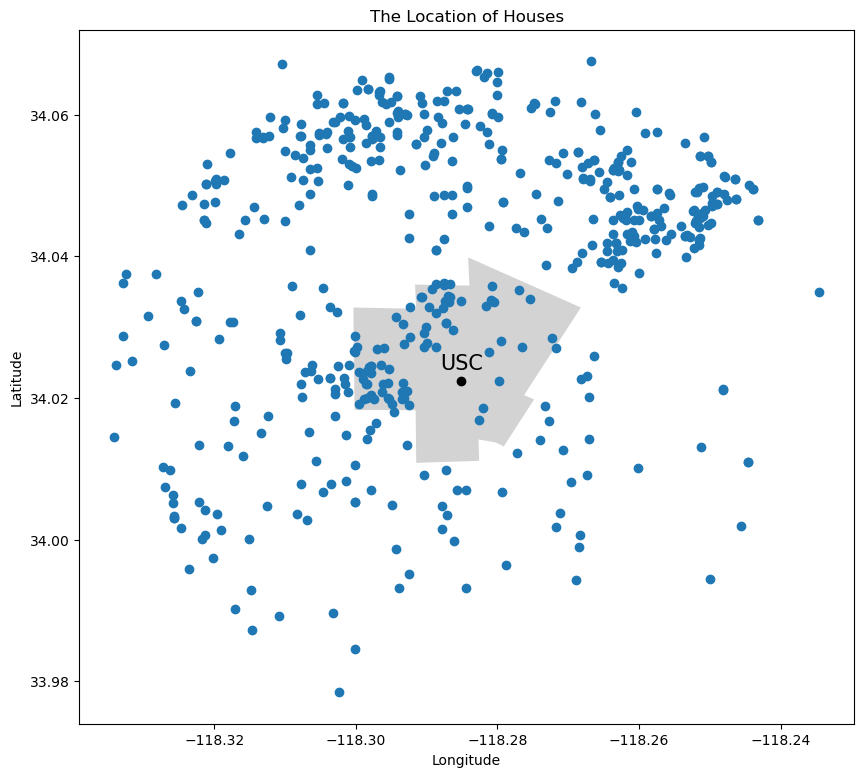

In [20]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])

# Load the GeoJSON file into a GeoDataFrame
gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

# store the latitude and longitude of a house together in a list
point_coords = [(long,lat) for lat,long in zip(lats,longs)]

# Convert the list of point coordinates into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                          [coord[1] for coord in point_coords]))

fig, ax = plt.subplots(figsize=(10, 10))
gdf_boundary.plot(ax=ax,color='lightgray') # plot the USC DPS zone
gdf_points.plot(ax=ax, marker='o') # plot each data point

# plot the position of USC
plt.scatter(-118.2851,34.0224, marker='o', color='black')
plt.text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)

plt.title('The Location of Houses')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Show the houses with their number of crimes noted as colors in a map. The houses in the second map is clickable.

In [21]:
# create a folium map object
m = folium.Map(location=[34.0522, -118.2437], zoom_start=13)

# add the USC DPS zone to the map
folium.GeoJson(
    data='UPC_Patrol_Boundaries.geojson',
    style_function=lambda x: {
        'color': 'blue',  # the color of the frame
        'fillColor': 'blue',  # to make it transparent, use 'transparent'
        'weight': 3,  # change the width of the frame
    }
).add_to(m)

data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])

colors=['red','orange','yellow','green','blue','indigo','violet']
points=[]
for lat,long,total in zip(lats,longs,totals):
    points.append({'lat':lat,'lon':long,'color':colors[total//50]})

# Add the points to the map
for point in points:
    folium.CircleMarker(location=[point['lat'], point['lon']], radius=3, color=point['color'], fill=True, fill_color=point['color']).add_to(m)

# add a marker on the location of USC on the map
folium.Marker(
    location=[34.0224, -118.2851],
    icon=folium.Icon(color='green'),
    popup='<font size="3">USC</font>'
).add_to(m)

# save the map
m.save('houses_crime1.html')
m

In [22]:
# create a folium map object
m = folium.Map(location=[34.0522, -118.2437], zoom_start=13)

# add the USC DPS zone to the map
folium.GeoJson(
    data='UPC_Patrol_Boundaries.geojson',
    style_function=lambda x: {
        'color': 'blue',  # the color of the frame
        'fillColor': 'blue',  # to make it transparent, use 'transparent'
        'weight': 3,  # change the width of the frame
    }
).add_to(m)

data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])
names=list(data['Name'])

colors=['red','orange','lightgreen','green','blue','darkblue','purple']
points=[]
for name,lat,long,total in zip(names,lats,longs,totals):
    points.append({'name':name,'lat':lat,'lon':long,'color':colors[total//50],'total':total})

# Add the points as markers to the map
for point in points:
    folium.Marker(
        location=[point['lat'],point['lon']],
        icon=folium.Icon(color=point['color']),
        popup=f'<font size="3">{point["name"]}, {point["total"]}</font>'
    ).add_to(m)

# add a marker on the location of USC on the map
folium.Marker(
    location=[34.0224, -118.2851],
    icon=folium.Icon(color='green'),
    popup='<font size="3">USC</font>'
).add_to(m)

# save the map
m.save('houses_crime2.html')
m

Plot the houses with their number of crimes noted as colors.

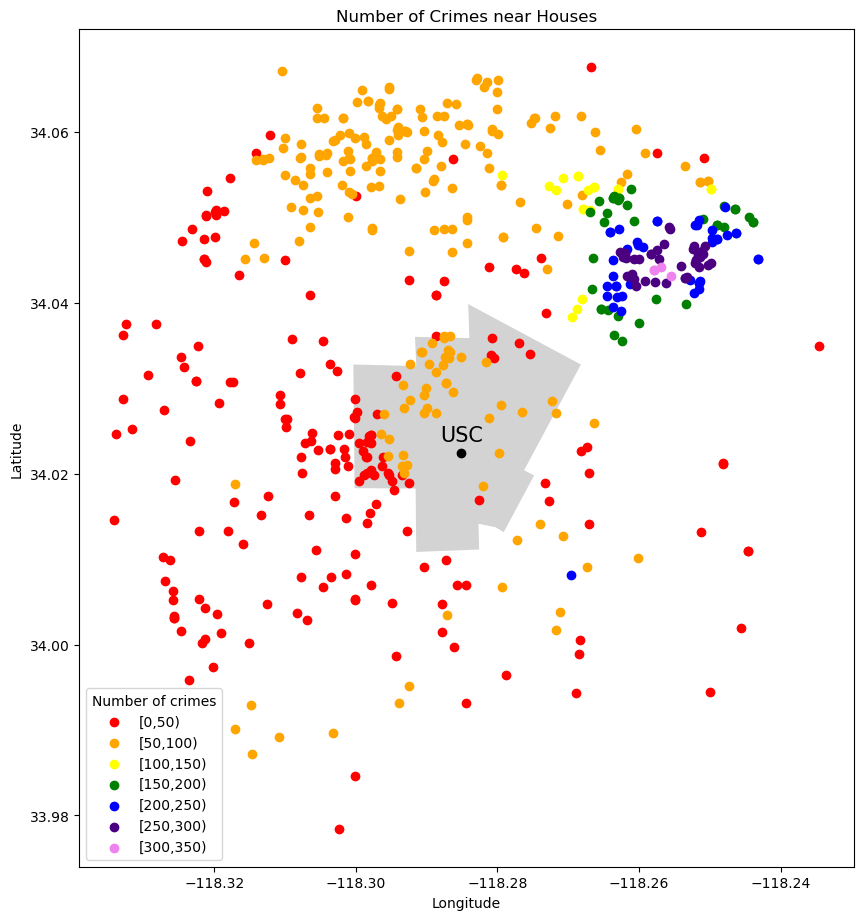

In [23]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])
# Load the GeoJSON file into a GeoDataFrame
gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

# store the latitude and longitude of a house together in a list
point_coords = [(long,lat) for lat,long in zip(lats,longs)]

# Convert the list of point coordinates into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                        [coord[1] for coord in point_coords]))

# define the color and its tag for each data point
colors=['red','orange','yellow','green','blue','indigo','violet']
tags=['[0,50)','[50,100)','[100,150)','[150,200)','[200,250)','[250,300)','[300,350)']

gdf_points['color'] = [colors[total//50] for total in totals]
gdf_points['value'] = [tags[total//50] for total in totals]

fig,ax=plt.subplots(figsize=(10, 50))

gdf_boundary.plot(ax=ax,color='lightgray') # plot the USC DPS zone
# plot each data point
for color,tag in zip(colors,tags):
    ax.scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
            gdf_points[gdf_points['color'] == color]['geometry'].y,
            color=color,
            label=tag)
ax.legend(title='Number of crimes')
# plot the position of USC
ax.scatter(-118.2851,34.0224, marker='o', color='black')
ax.text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)

ax.set_title('Number of Crimes near Houses')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Plot the same graph with four separating lines.

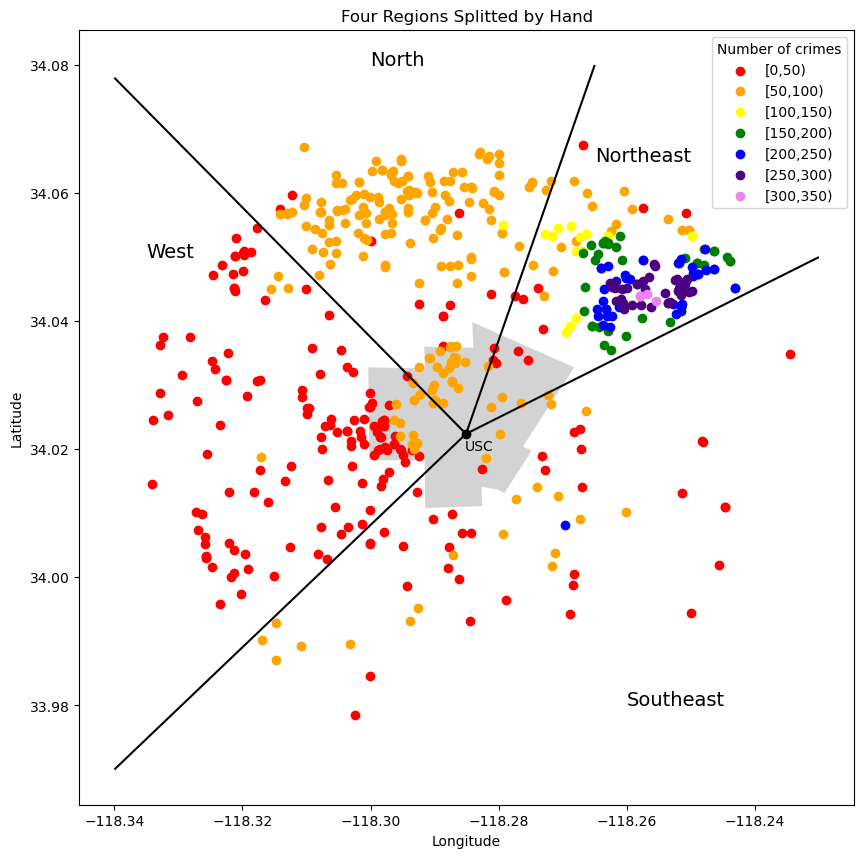

In [24]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])
# Load the GeoJSON file into a GeoDataFrame
gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

# store the latitude and longitude of a house together in a list
point_coords = [(long,lat) for lat,long in zip(lats,longs)]

# Convert the list of point coordinates into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                        [coord[1] for coord in point_coords]))

# define the color and its tag for each data point
colors=['red','orange','yellow','green','blue','indigo','violet']
tags=['[0,50)','[50,100)','[100,150)','[150,200)','[200,250)','[250,300)','[300,350)']

gdf_points['color'] = [colors[total//50] for total in totals]
gdf_points['value'] = [tags[total//50] for total in totals]

fig,ax=plt.subplots(figsize=(10, 50))

gdf_boundary.plot(ax=ax,color='lightgray') # plot the USC DPS zone
# plot each data point
for color,tag in zip(colors,tags):
    ax.scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
            gdf_points[gdf_points['color'] == color]['geometry'].y,
            color=color,
            label=tag)
ax.legend(title='Number of crimes')
# plot the position of USC
ax.scatter(-118.2851,34.0224, marker='o', color='black')
ax.text(-118.283,34.0194, 'USC', ha='center', va='bottom', color='black',fontsize=10)
ax.set_title('Four Regions Splitted by Hand')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# draw the separation lines
for coord in [[(-118.2851,34.0224),(-118.23, 34.05)],[(-118.2851,34.0224),(-118.265, 34.08)],[(-118.2851,34.0224),(-118.34, 34.078)],[(-118.2851,34.0224),(-118.34, 33.97)]]:
    line=LineString(coord)
    gpd.GeoSeries([line]).plot(ax=ax, color='black')

text_positions=[(-118.26,33.98),(-118.265,34.065),(-118.3,34.08),(-118.335,34.05)]
texts=['Southeast','Northeast','North','West']
for text,position in zip(texts,text_positions):
    ax.annotate(text, xy=position, xytext=position,fontsize=14)

plt.show()

Plot the houses with their number of crime noted as colors, more detailedly.

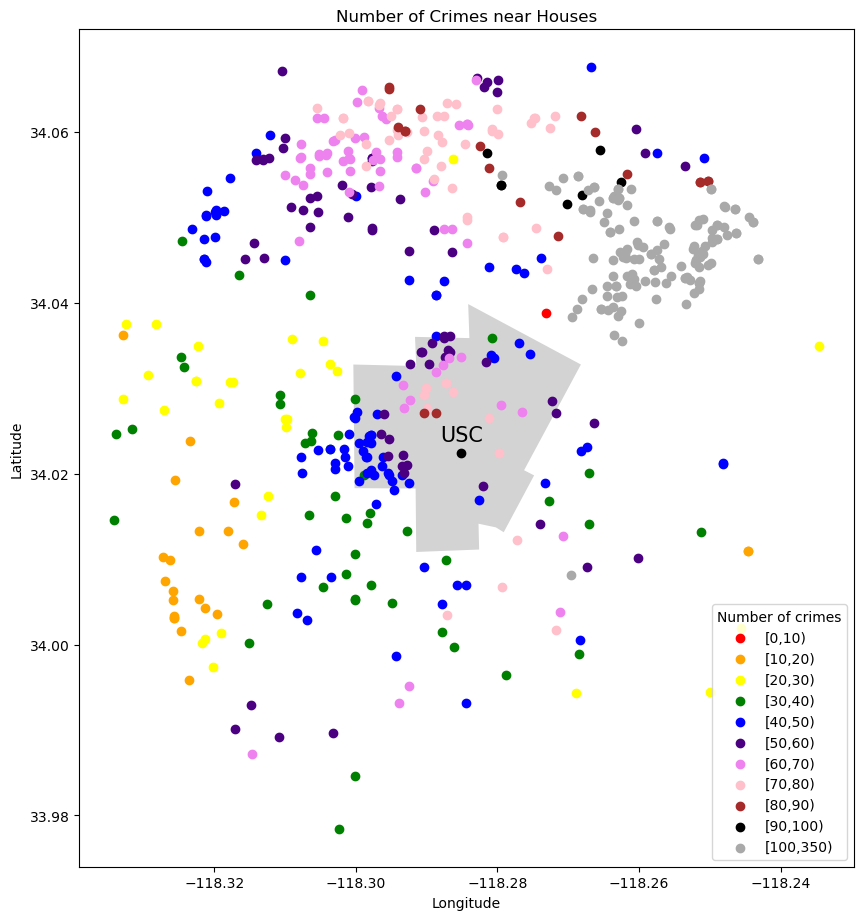

In [25]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])
# Load the GeoJSON file into a GeoDataFrame
gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

# store the latitude and longitude of a house together in a list
point_coords = [(long,lat) for lat,long in zip(lats,longs)]

# Convert the list of point coordinates into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                          [coord[1] for coord in point_coords]))

# define the color and its tag for each data point
colors=['red','orange','yellow','green','blue','indigo','violet','pink','brown','black','darkgray']
tags=['[0,10)','[10,20)','[20,30)','[30,40)','[40,50)','[50,60)','[60,70)','[70,80)','[80,90)','[90,100)','[100,350)']

gdf_points['color'] = [colors[total//10] if total//10<10 else colors[-1] for total in totals]
gdf_points['value'] = [tags[total//50] if total//10<10 else tags[-1] for total in totals]

fig,ax=plt.subplots(figsize=(10, 50))

gdf_boundary.plot(ax=ax,color='lightgray') # plot the USC DPS zone
# plot each data point
for color,tag in zip(colors,tags):
    ax.scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
            gdf_points[gdf_points['color'] == color]['geometry'].y,
            color=color,
            label=tag)
ax.legend(title='Number of crimes')
# plot the position of USC
ax.scatter(-118.2851,34.0224, marker='o', color='black')
ax.text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)

ax.set_title('Number of Crimes near Houses')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Perform linear regression on longitude and total number of crimes.

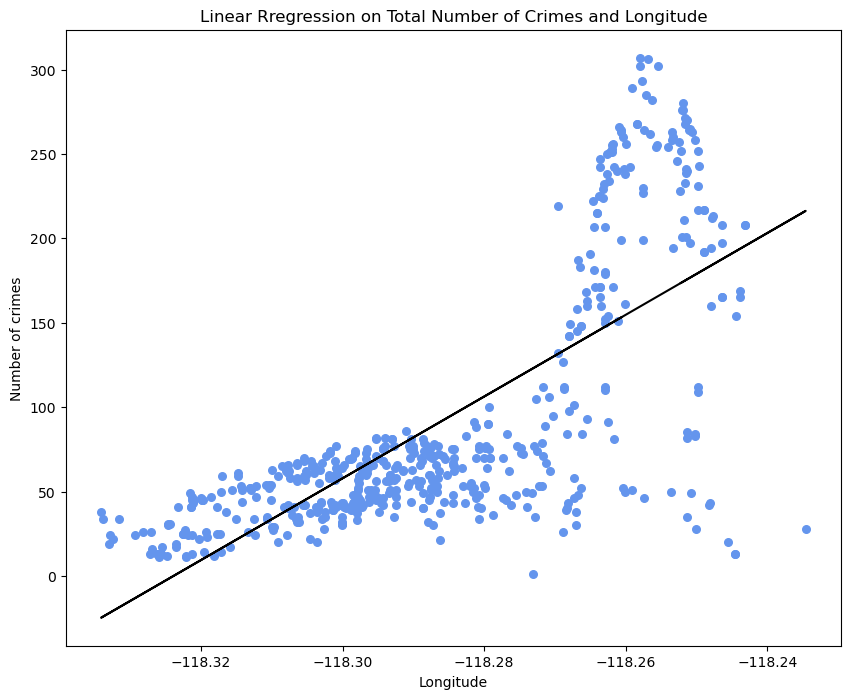

For this linear regression, the R² is 0.5326112675718968


In [26]:
data=pd.read_csv('whole_dataset.csv')
X=pd.DataFrame(data['Longitude'])
y=data['Total']

reg=LinearRegression()
reg.fit(X,y)
y_pred=reg.predict(X)

plt.figure(figsize=(10,8))
# plot the data points
plt.scatter(X,y,c='cornflowerblue',s=30)
# plot the regression line
plt.plot(X,y_pred,color='black')

plt.title(f'Linear Rregression on Total Number of Crimes and Longitude')
plt.xlabel(f'Longitude')
plt.ylabel(f'Number of crimes')
plt.show()
print(f'For this linear regression, the R\u00b2 is {reg.score(X,y)}')

Perform polynomial regressions on longitude and total.

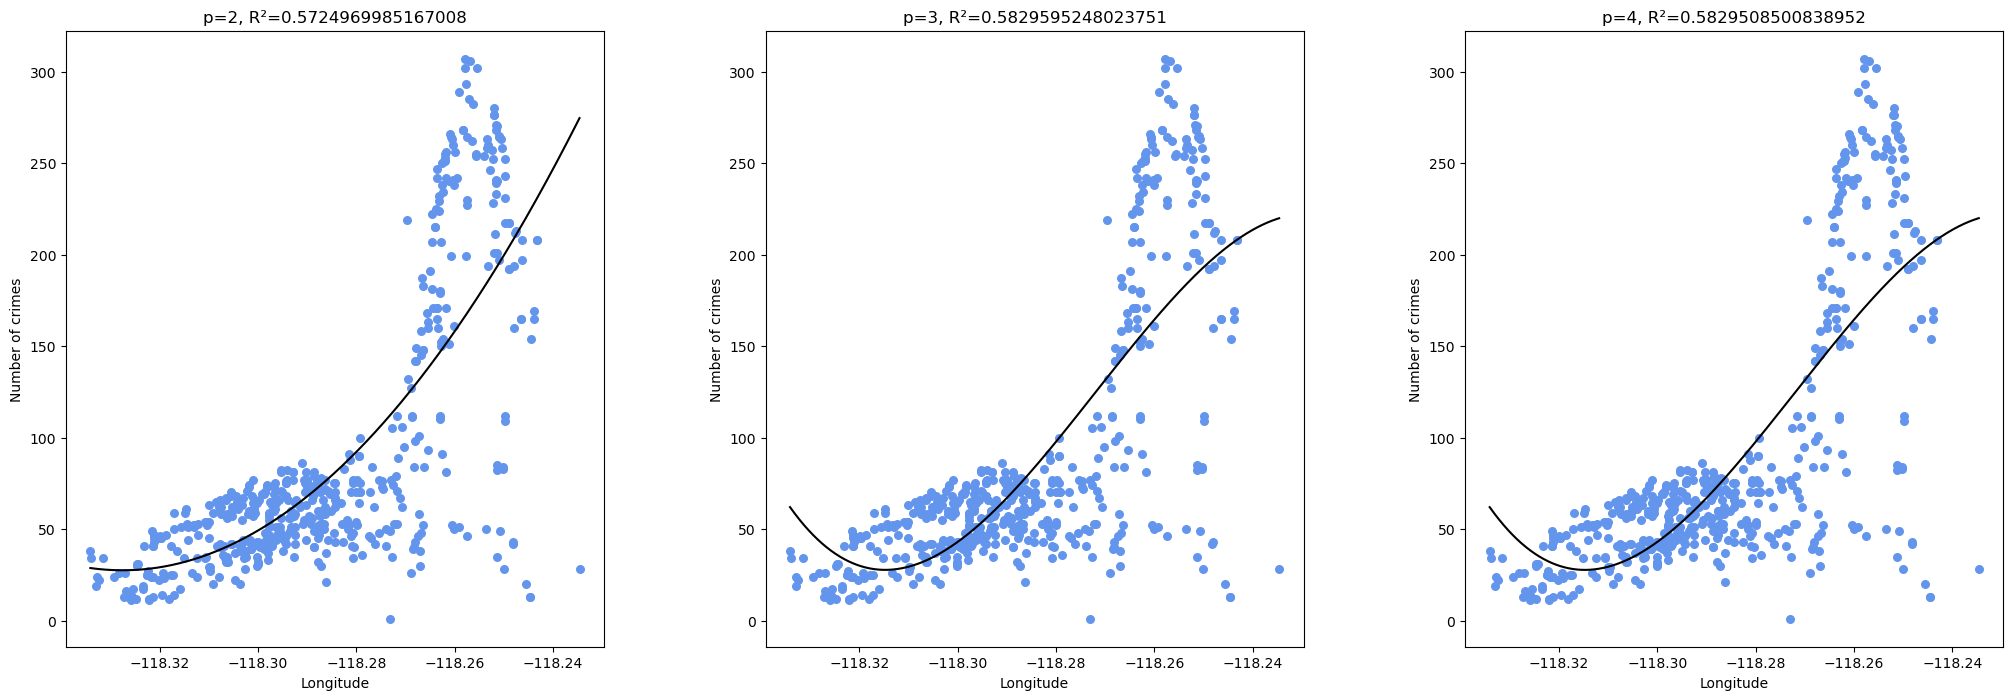

In [27]:
data=pd.read_csv('whole_dataset.csv')
X=np.array(data['Longitude']).reshape(X.shape[0],1)
y=data['Total']

plt.figure(figsize=(25,8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.3)
for max_power in range(2,5):
    # obtain higher dimension terms of X
    poly=PolynomialFeatures((1,max_power),interaction_only=False,include_bias=False)
    X_p=poly.fit_transform(X)

    reg=LinearRegression()
    reg.fit(X_p,y)
    
    # plot the data points
    plt.subplot(1,3,max_power-1)
    plt.scatter(X,y,c='cornflowerblue',s=30)

    # plot the regression curve
    xs=np.arange(min(X)[0],max(X)[0],0.0001)
    ys=np.array([reg.intercept_+sum(reg.coef_[power]*pow(x,power+1) for power in range(max_power)) for x in xs])
    plt.plot(xs,ys,color='black')

    plt.title(f'p={max_power}, R\u00b2={reg.score(X_p,y)}')
    plt.xlabel(f'Longitude')
    plt.ylabel(f'Number of crimes')

plt.show()

## 3. Perform K-means Clustering

In [28]:
# find the optimal number of clusters with the limit of maximum number
def find_best_k(X,max_num):
    CH_scores=[]
    for k in range(2, max_num+1):
        kmeans = KMeans(n_clusters=k,n_init='auto',random_state=0).fit(X)
        s_score = calinski_harabasz_score(X, kmeans.labels_)
        CH_scores.append(s_score)
                
    optimal_k = CH_scores.index(max(CH_scores))+2
    return optimal_k

# obtain and draw the clusters by k-means
def find_relationship(x):
    data=pd.read_csv('whole_dataset.csv')
    X=data[x]
    lats=list(data['Latitude'])
    longs=list(data['Longitude'])

    # Load the GeoJSON file into a GeoDataFrame
    gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

    # find the optimal number of clusters
    optimal_k=find_best_k(X,7)

    # refit the K-Means cluster with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0,n_init='auto').fit(X)

    print(f'There are {optimal_k} clusters.')

    # get which cluster each data point belongs to
    cluster_indexes=kmeans.labels_
    colors=['red','orange','yellow','green','blue','indigo','violet']

    fig, ax = plt.subplots(figsize=(10, 50))

    gdf_boundary.plot(ax=ax, color='lightgray') # plot the USC DPS zone
    # plot each data point
    for i in range(len(lats)):
        plt.scatter(longs[i],lats[i],color=colors[cluster_indexes[i]])

    # plot the position of USC
    ax.scatter(-118.2851,34.0224, marker='o', color='black')
    ax.text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)
    
    plt.title(f'{optimal_k} Clusters by K-means')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

Do k-means clustering on different groups of variables.

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


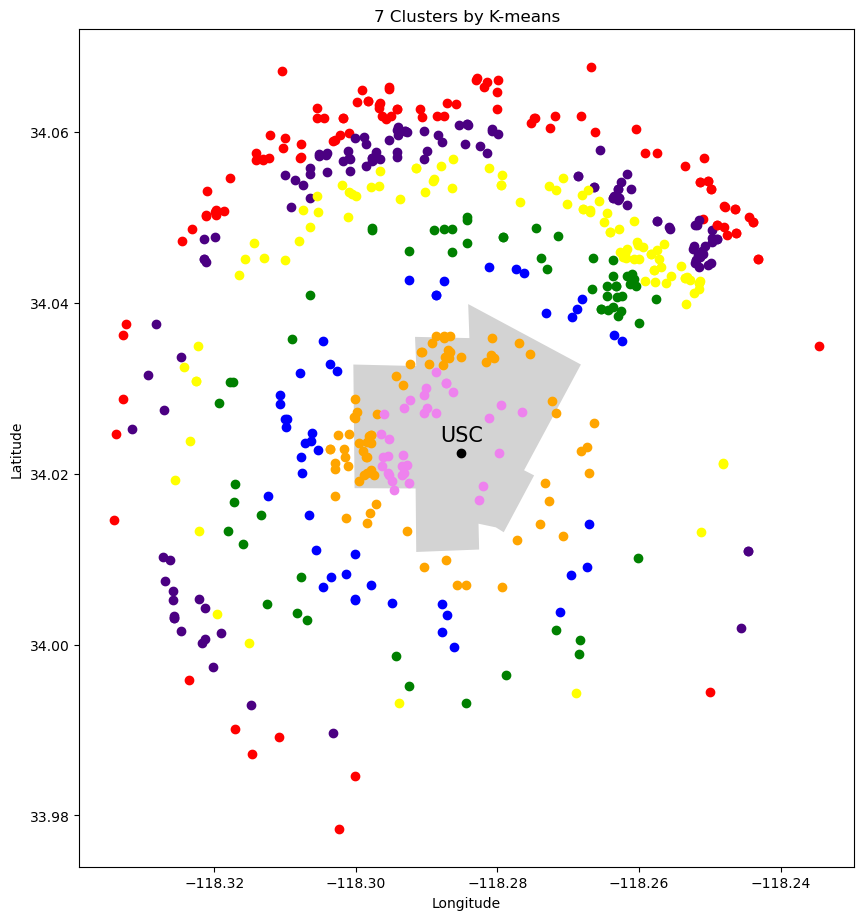

In [29]:
x=['Distance(meter)']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


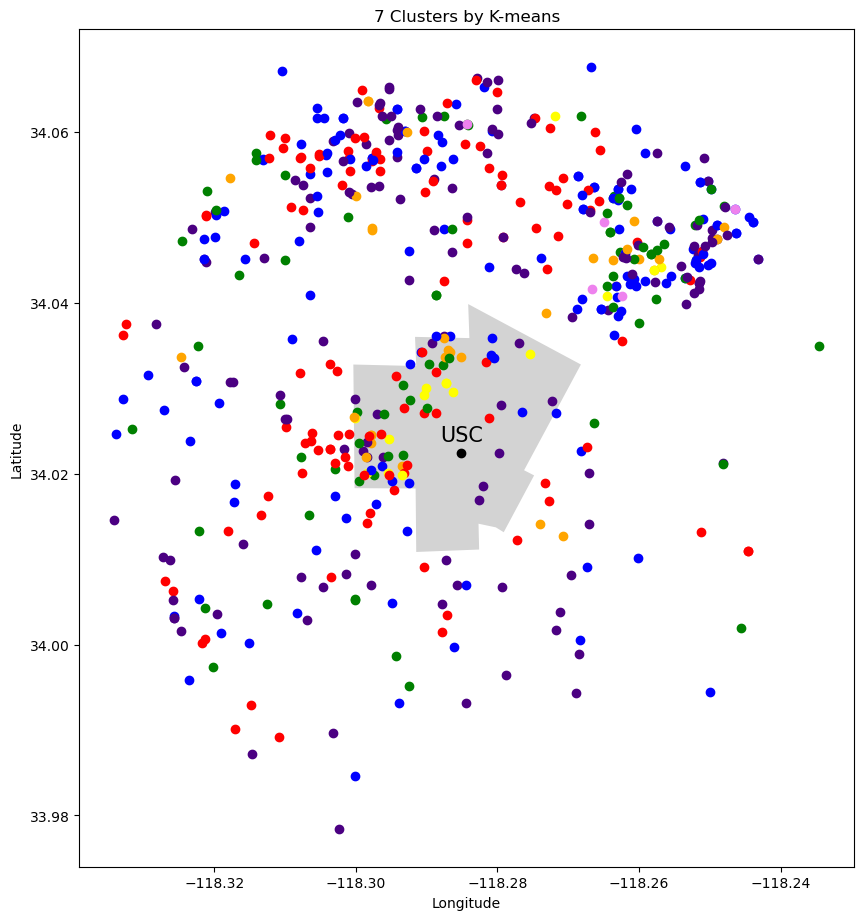

In [30]:
x=['Price(in $)']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


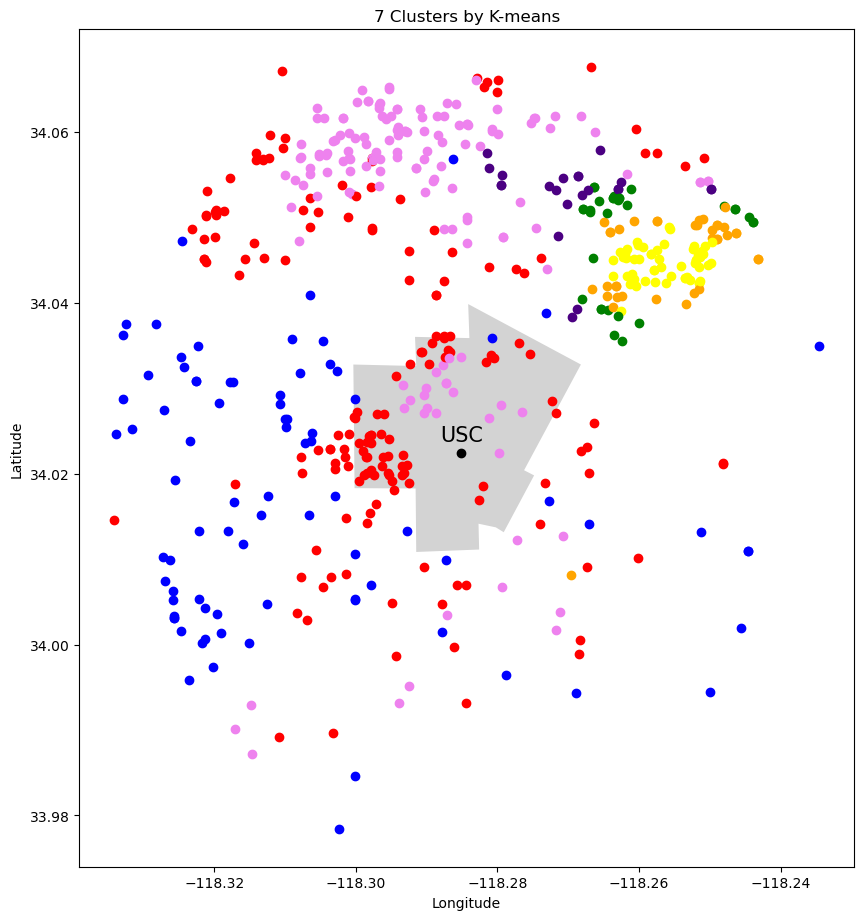

In [31]:
x=['Total']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 5 clusters.


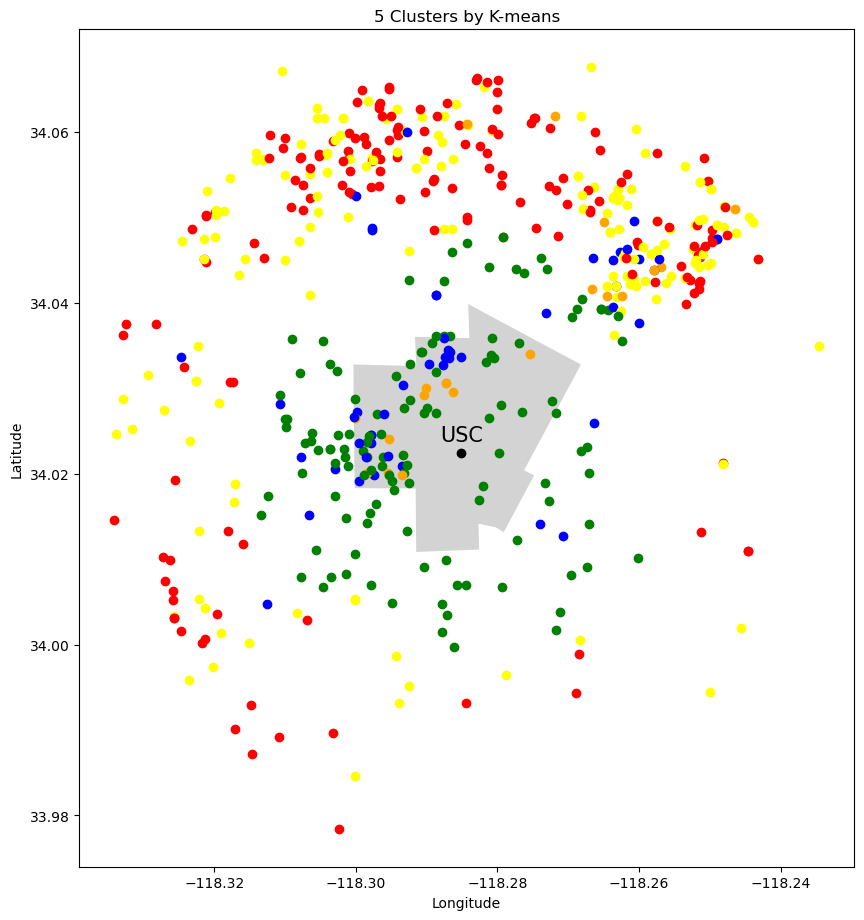

In [32]:
x=['Distance(meter)','Longitude','Latitude','Price(in $)','Total']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


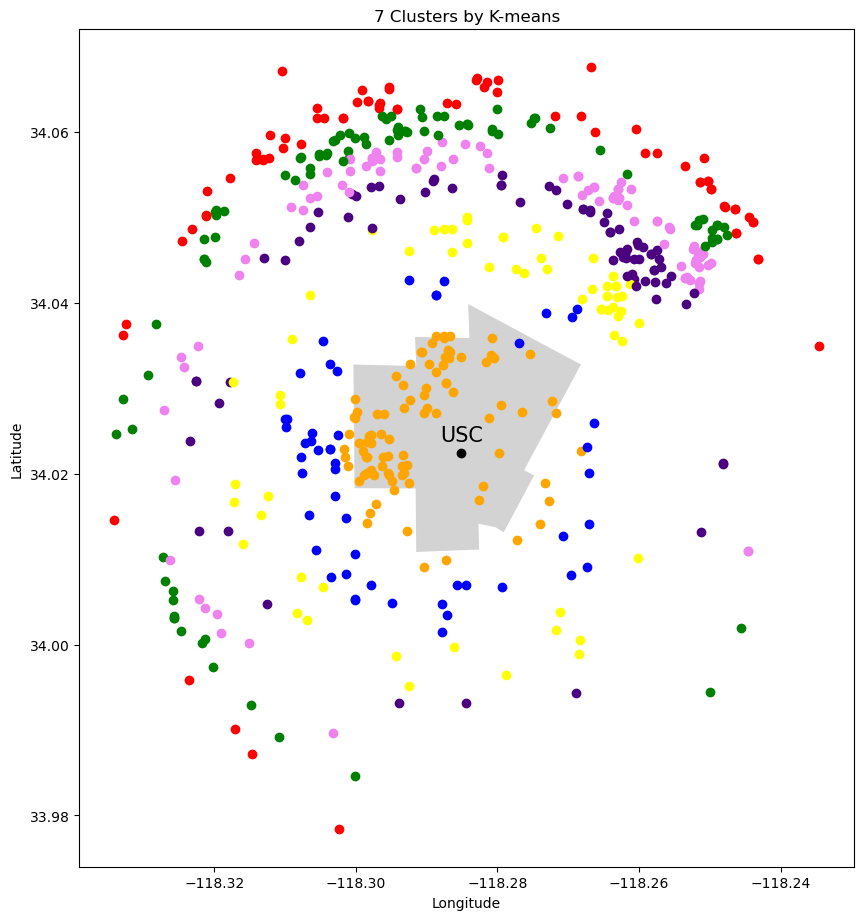

In [33]:
x=['Distance(meter)','Total']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


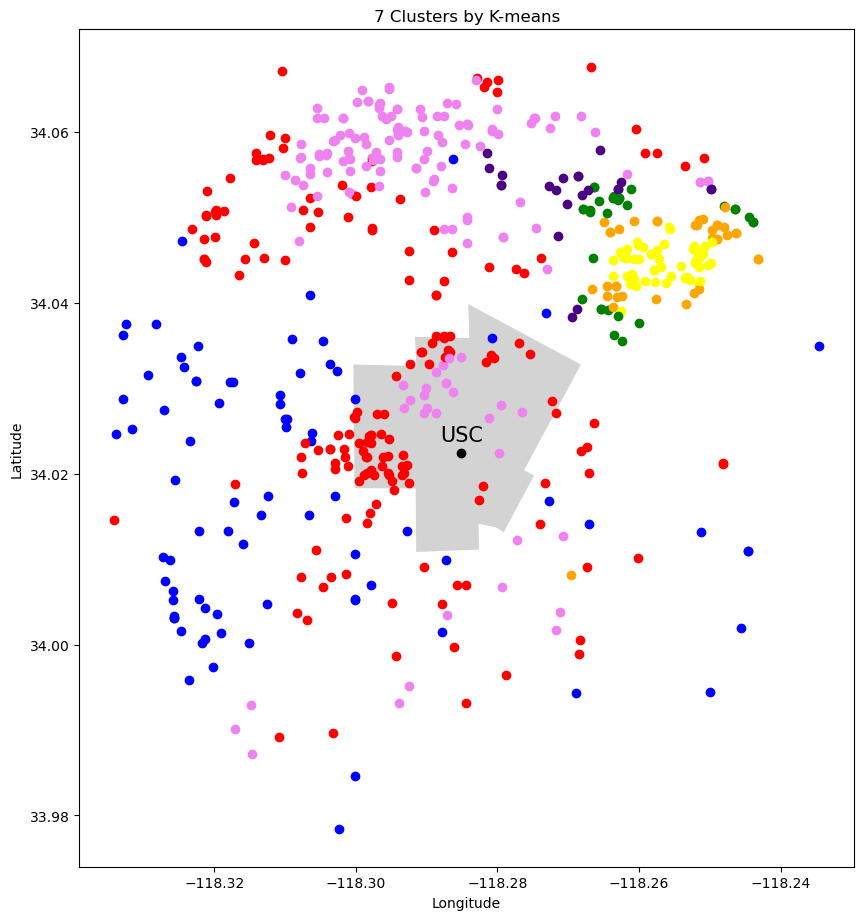

In [34]:
x=['Longitude','Latitude','Total']
find_relationship(x)

c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\32774\anaconda3\envs\dsci552\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarn

There are 7 clusters.


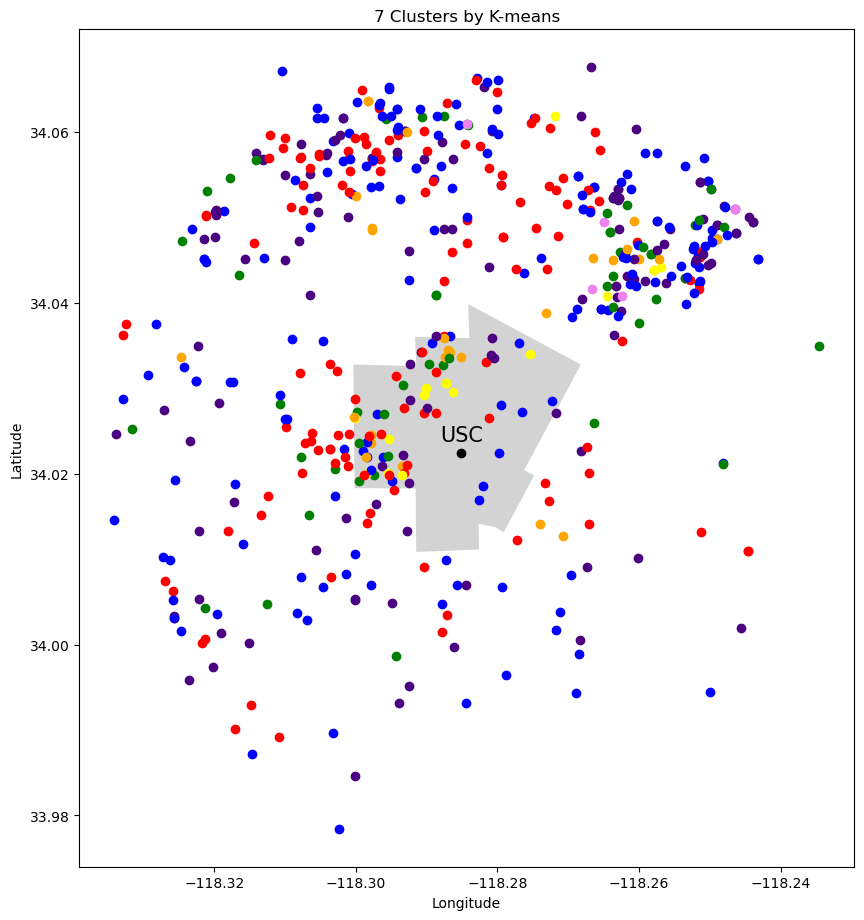

In [35]:
x=['Price(in $)','Total']
find_relationship(x)

Perform k-means based on x and y on the data and do linear regression on the cluster if there is some linear relationship between x and y.

## 4. Perform Regression on the Data Set

Calculate p-values of four input variables, when they are inputed to the linear regression model as a whole.

In [36]:
data=pd.read_csv('whole_dataset.csv')
Y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]

X2=sm.add_constant(X)
est=sm.OLS(Y,X2).fit()

output_table=pd.DataFrame({'Coefficient':est.params,'Std. Error':est.bse,'t-statistic':est.tvalues,'p-value':est.pvalues})
output_table

Coefficient    Std. Error  t-statistic       p-value
const            262254.306365  13403.328202    19.566357  9.268820e-65
Distance(meter)       0.009492      0.002072     4.580664  5.767553e-06
Longitude          2290.767096     97.201225    23.567266  7.477611e-85
Latitude            257.315162    136.246296     1.888603  5.948372e-02
Price(in $)           0.004123      0.001100     3.746860  1.984489e-04

Train the linear regression model and calculate the mean squared error on the test set.

In [37]:
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

reg=LinearRegression()
reg.fit(X_train,y_train)
print(f'For this linear regression with original input variables, the MSE is {mean_squared_error(y_test,reg.predict(X_test))}')

For this linear regression with original input variables, the MSE is 1932.0932697078715


Calculate the p-values of all of the terms when polynomial terms are added to the input.

In [38]:
data=pd.read_csv('whole_dataset.csv')
X_vars=['Distance(meter)','Longitude','Latitude','Price(in $)']
y=data['Total']
X=[]
output_table={'Coefficient':None,'Std. Error':None,'t-statistic':None,'p-value':None}
for var in X_vars:
    X1=pd.DataFrame(data[var])
    # obtain higher dimension terms of X
    poly=PolynomialFeatures((1,3),interaction_only=False,include_bias=False)
    X1=pd.DataFrame(poly.fit_transform(X1))
    X1.columns=[var,f'{var}\u00b2',f'{var}\u00b3']
    X.append(X1)

    X2=sm.add_constant(X1)
    est=sm.OLS(y,X2).fit()

    output_table['Coefficient']=pd.concat([output_table['Coefficient'],est.params[1:4]])
    output_table['Std. Error']=pd.concat([output_table['Std. Error'],est.bse[1:4]])
    output_table['t-statistic']=pd.concat([output_table['t-statistic'],est.tvalues[1:4]])
    output_table['p-value']=pd.concat([output_table['p-value'],est.pvalues[1:4]])

output_table=pd.DataFrame(output_table)
output_table

Coefficient    Std. Error  t-statistic       p-value
Distance(meter)  -1.402633e-01  4.673138e-02    -3.001479  2.811407e-03
Distance(meter)²  7.624419e-05  1.730054e-05     4.407041  1.265404e-05
Distance(meter)³ -1.032319e-08  1.954304e-09    -5.282285  1.855686e-07
Longitude        -3.384449e+06  4.765231e+05    -7.102382  3.894995e-12
Longitude²       -5.722314e+04  8.059778e+03    -7.099840  3.961080e-12
Longitude³       -2.418256e+02  3.407290e+01    -7.097300  4.028211e-12
Latitude         -1.216789e+10  1.071942e+09   -11.351253  6.407911e-27
Latitude²         3.576180e+08  3.150082e+07    11.352654  6.325571e-27
Latitude³        -3.503498e+06  3.085681e+05   -11.354054  6.244397e-27
Price(in $)       3.258593e-02  1.124766e-02     2.897130  3.919286e-03
Price(in $)²     -4.392191e-06  2.029401e-06    -2.164280  3.088213e-02
Price(in $)³      1.946376e-10  1.009744e-10     1.927593  5.443191e-02

Remove the high p-value terms, then train the linear regression model and calculate the mean squared error on the test set.

In [39]:
# train the polynomial regression model and calculate the mean squared error on the test set.
X=pd.concat(X,axis=1)
X=X.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

reg=LinearRegression()
reg.fit(X_train,y_train)
print(f'For this linear regression with quadratic and cubic terms, the MSE is {mean_squared_error(y_test,reg.predict(X_test))}')

For this linear regression with quadratic and cubic terms, the MSE is 1741.1146011870574


Calculate the p-values of all of the terms when interaction terms are added to the input.

In [40]:
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
columns=['Distance(meter)','Longitude','Latitude','Price(in $)']
X=data[columns]
# obtain interaction terms of X
poly=PolynomialFeatures(interaction_only=True,include_bias=False)
X=pd.DataFrame(poly.fit_transform(X))
X.columns=columns+[f'{columns[i]}\u00D7{columns[j]}' for i in range(len(columns)-1) for j in range(i+1,len(columns))]

X2=sm.add_constant(X)
est=sm.OLS(y,X2).fit()

output_table=pd.DataFrame({'Coefficient':est.params,'Std. Error':est.bse,'t-statistic':est.tvalues,'p-value':est.pvalues})
output_table

Coefficient    Std. Error  t-statistic  \
const                       -1.587594e+08  2.482195e+07    -6.395927   
Distance(meter)             -6.065739e+01  1.642590e+01    -3.692790   
Longitude                   -1.341350e+06  2.098723e+05    -6.391267   
Latitude                     4.678757e+06  7.299880e+05     6.409362   
Price(in $)                  2.502050e+01  8.450176e+00     2.960944   
Distance(meter)×Longitude   -6.354476e-01  1.217304e-01    -5.220121   
Distance(meter)×Latitude    -4.264078e-01  1.313576e-01    -3.246160   
Distance(meter)×Price(in $)  1.706314e-06  1.190434e-06     1.433354   
Longitude×Latitude           3.953063e+04  6.172129e+03     6.404699   
Longitude×Price(in $)        1.636518e-01  5.995051e-02     2.729781   
Latitude×Price(in $)        -1.664358e-01  1.094544e-01    -1.520595   

                                  p-value  
const                        3.503212e-10  
Distance(meter)              2.447593e-04  
Longitude                    3.603802e-10  
Latitude                     3.228352e-10  
Price(in $)                  3.204123e-03  
Distance(meter)×Longitude    2.569913e-07  
Distance(meter)×Latitude     1.243506e-03  
Distance(meter)×Price(in $)  1.523451e-01  
Longitude×Latitude           3.321268e-10  
Longitude×Price(in $)        6.548012e-03  
Latitude×Price(in $)         1.289566e-01

Remove the high p-value terms, then train the linear regression model and calculate the mean squared error on the test set.

In [41]:
# train the linear regression model with interaction terms and calculate the mean squared error on the test set.
X=X.drop(X.columns[[6, 9]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

reg=LinearRegression()
reg.fit(X_train,y_train)
print(f'For this linear regression with interaction terms, the MSE is {mean_squared_error(y_test,reg.predict(X_test))}')

For this linear regression with interaction terms, the MSE is 1561.8208617392258


Integrade all the terms in the last two steps, do feature selection on these terms, then train the linear regression model and calculate the mean squared error on the test set.

In [42]:
# given all the possible terms as input variables, find the best group and train the model, then calculate the MSE on test set.
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]

poly=PolynomialFeatures(3,interaction_only=False,include_bias=False)
X=pd.DataFrame(poly.fit_transform(X))
print(f'There are {X.shape[1]} variables in total.')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

selectors=[]
CV_scores=[]
# iterate through all possible number of input variables to find the best group.
for i in range(X.shape[1]):
    selector = RFE(LinearRegression(),n_features_to_select=i+1,step=1)
    selector.fit(X_train,y_train)
    selectors.append(selector)

    X_train_selected = selector.transform(X_train)
    CV_score=cross_val_score(LinearRegression(),X_train_selected,y_train).mean() # use cross-validation to calculate the score.
    CV_scores.append(CV_score)

best_selector=selectors[CV_scores.index(max(CV_scores))]
X_train=best_selector.transform(X_train)
X_test=best_selector.transform(X_test)

reg=LinearRegression()
reg.fit(X_train,y_train)
print(f'The best group of variabels contains {X_train.shape[1]} variabels.\nFor this linear regression with feature selection, the MSE is {mean_squared_error(y_test,reg.predict(X_test))}')

There are 34 variables in total.
The best group of variabels contains 24 variabels.
For this linear regression with feature selection, the MSE is 509.04311695396166


Train models: decision tree regressor, support vector regressor and multi-layer perceptron regressor, and calculate the mean squared error on the test set.

In [43]:
# train the decition tree regression model and calculate the mean squared error on the test set.
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

DTR = DecisionTreeRegressor(max_depth=10)
DTR.fit(X_train,y_train)
print(f'For this decision tree regression, the MSE is {mean_squared_error(y_test,DTR.predict(X_test))}')

For this decision tree regression, the MSE is 169.81284343060173


In [44]:
# train the support vector regression model and calculate the mean squared error on the test set.
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ,'Latitude'
svr=SVR()
svr.fit(X_train,y_train)
print(f'For this support vector regression with original input variables, the MSE is {mean_squared_error(y_test,svr.predict(X_test))}')

For this support vector regression with original input variables, the MSE is 5408.491905089194


In [45]:
# train the multi-layer perceptron regression model and calculate the mean squared error on the test set.
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 'Latitude',
MLPR= MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, solver='adam', activation='relu',random_state=0)
MLPR.fit(X_train,y_train)
print(f'For this multi-layer perceptron regression with original input variables, the MSE is {mean_squared_error(y_test,MLPR.predict(X_test))}')

For this multi-layer perceptron regression with original input variables, the MSE is 4989.1535359642785


## 5. Perform Classification on the Data Set

In [46]:
# function of drawing the classification result
def draw_classification(X_test,y_test,y_pred):
    lats=list(X_test['Latitude'])
    longs=list(X_test['Longitude'])
    # Load the GeoJSON file into a GeoDataFrame
    gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

    # store the latitude and longitude of a house together in a list
    point_coords = [(long,lat) for lat,long in zip(lats,longs)]

    # Convert the list of point coordinates into a GeoDataFrame
    gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                            [coord[1] for coord in point_coords]))

    # define the color and its tag for each data point
    colors=['red','orange','yellow','green','blue','indigo','violet']
    tags=['[0,50)','[50,100)','[100,150)','[150,200)','[200,250)','[250,300)','[300,350)']

    gdf_points['color'] = [colors[class_num] for class_num in y_test]
    gdf_points['value'] = [tags[class_num] for class_num in y_test]

    fig,axs=plt.subplots(1,2,figsize=(18, 20))

    gdf_boundary.plot(ax=axs[0],color='lightgray') # plot the USC DPS zone
    # plot each data point
    for color,tag in zip(colors,tags):
        axs[0].scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
                gdf_points[gdf_points['color'] == color]['geometry'].y,
                color=color,
                label=tag)
    axs[0].legend(title='Number of crimes')
    # plot the position of USC
    axs[0].scatter(-118.2851,34.0224, marker='o', color='black')
    axs[0].text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)

    axs[0].set_title('True Label for Houses')
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')

    gdf_points['color'] = [colors[class_num] for class_num in y_pred]
    gdf_points['value'] = [tags[class_num] for class_num in y_pred]

    gdf_boundary.plot(ax=axs[1],color='lightgray') # plot the USC DPS zone
    # plot each data point
    for color,tag in zip(colors,tags):
        axs[1].scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
                gdf_points[gdf_points['color'] == color]['geometry'].y,
                color=color,
                label=tag)
    axs[1].legend(title='Number of crimes')
    # plot the position of USC
    axs[1].scatter(-118.2851,34.0224, marker='o', color='black')
    axs[1].text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)
    
    axs[1].set_title('Predicted Label for Houses')
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')

    plt.show()

Train models: decision tree classifier, support vector classifier and multi-layer perceptron classifier, calculate the accuracy rate on the test set, and draw the result classification plots.

For this decision tree classification, the accuracy rate is 0.8532110091743119.


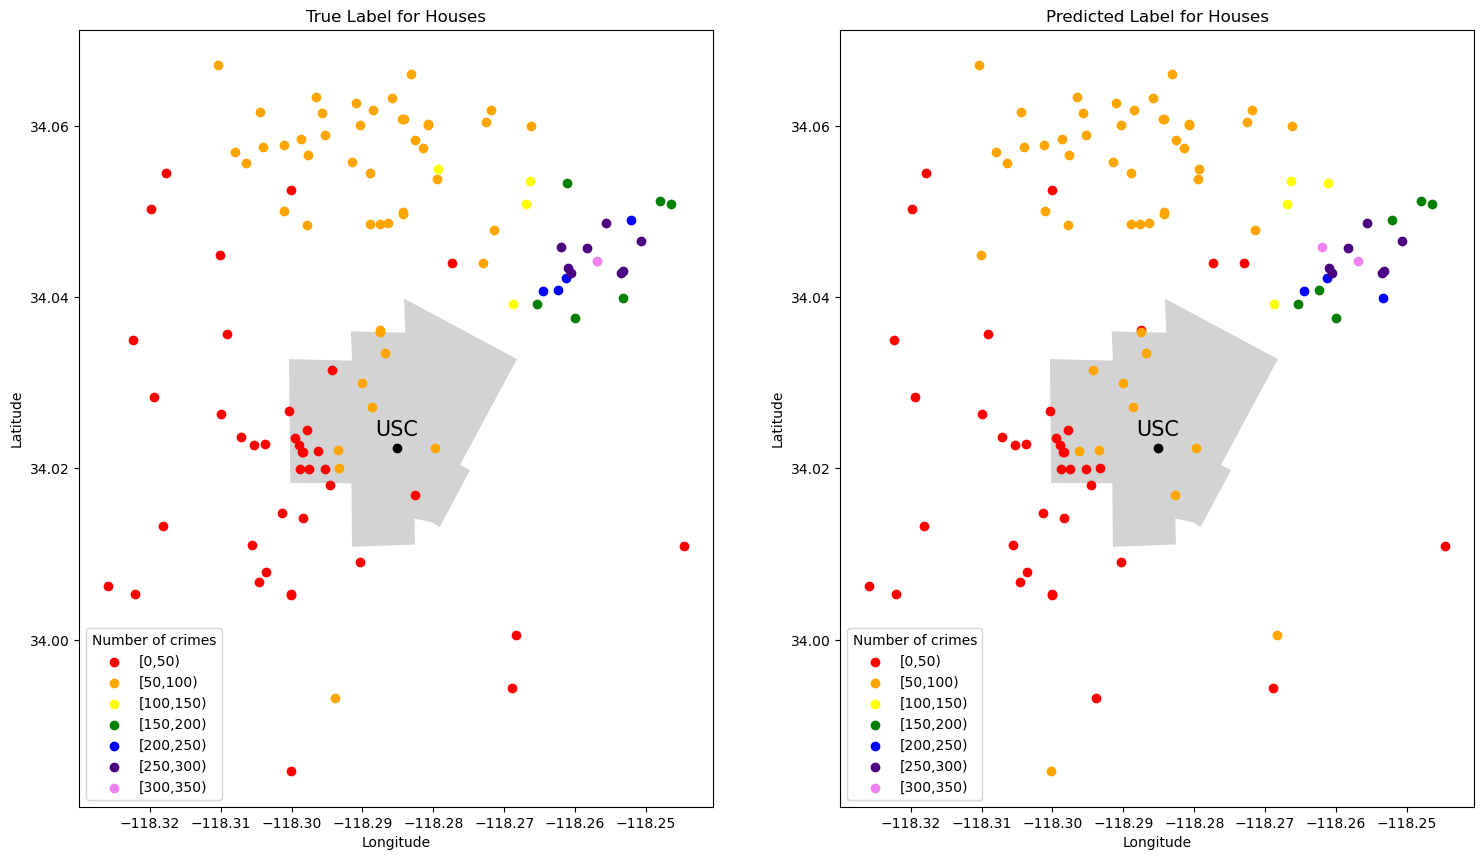

In [47]:
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]

y_values=[crime_num//50 for crime_num in y] # convert the numeric features to categorical
y=np.array(y_values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

# train the decision tree classification model and calculate the accuracy rate on the test set.
DTC=DecisionTreeClassifier(max_depth=10)
DTC.fit(X_train,y_train)
y_pred=DTC.predict(X_test)
print(f'For this decision tree classification, the accuracy rate is {accuracy_score(y_test,y_pred)}.')
draw_classification(X_test,y_test,y_pred)

For this support vector classification, the accuracy rate is 0.5412844036697247.


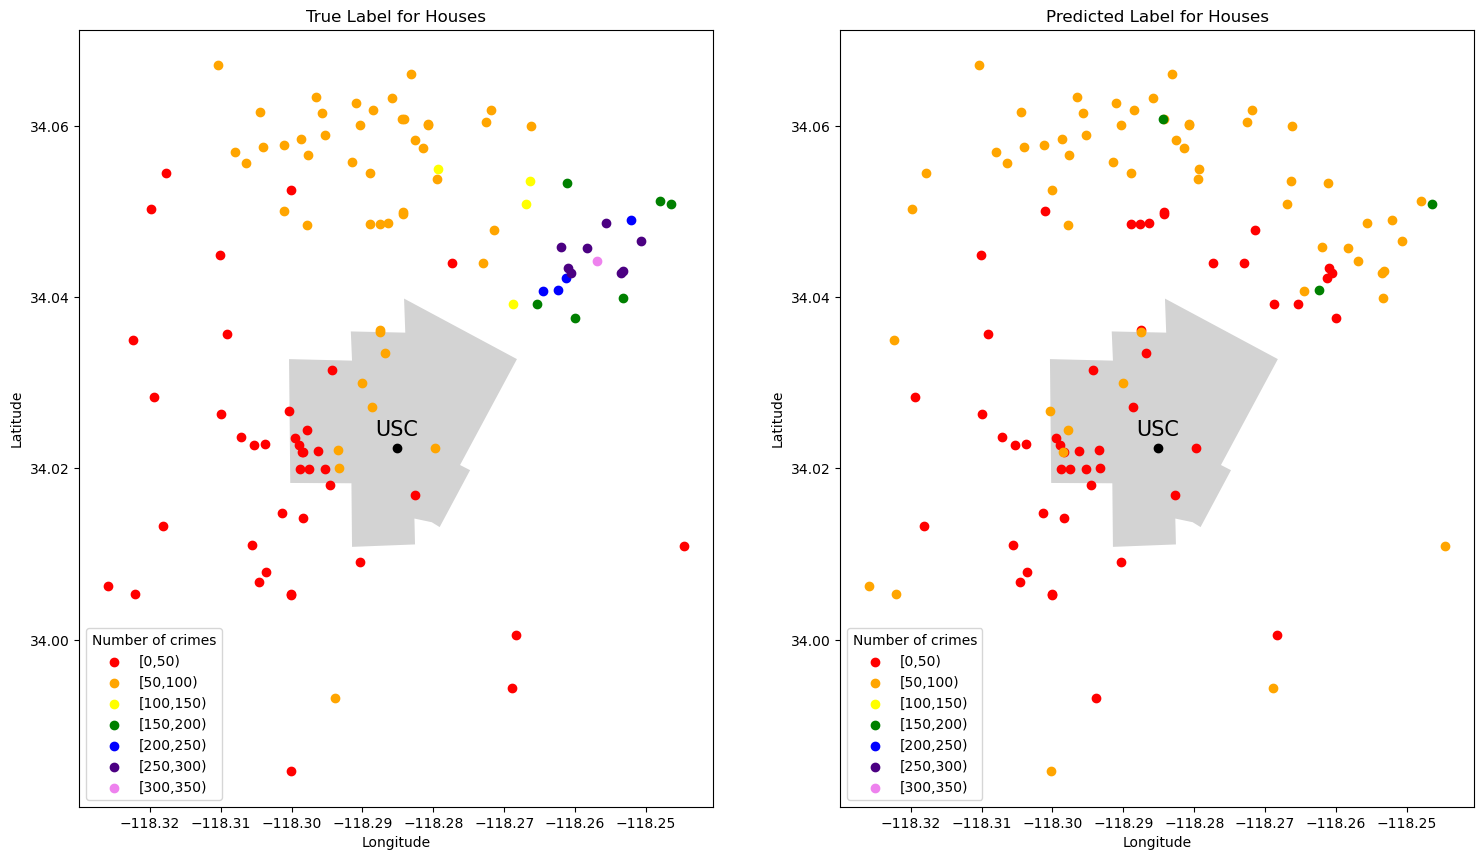

In [48]:
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]

y_values=[crime_num//50 for crime_num in y] # convert the numeric features to categorical
y=np.array(y_values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

# train the support vector classification model and calculate the accuracy rate on the test set.
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print(f'For this support vector classification, the accuracy rate is {accuracy_score(y_test,y_pred)}.')
draw_classification(X_test,y_test,y_pred)

For this multi-layer perceptron classification, the accuracy rate is 0.5504587155963303.


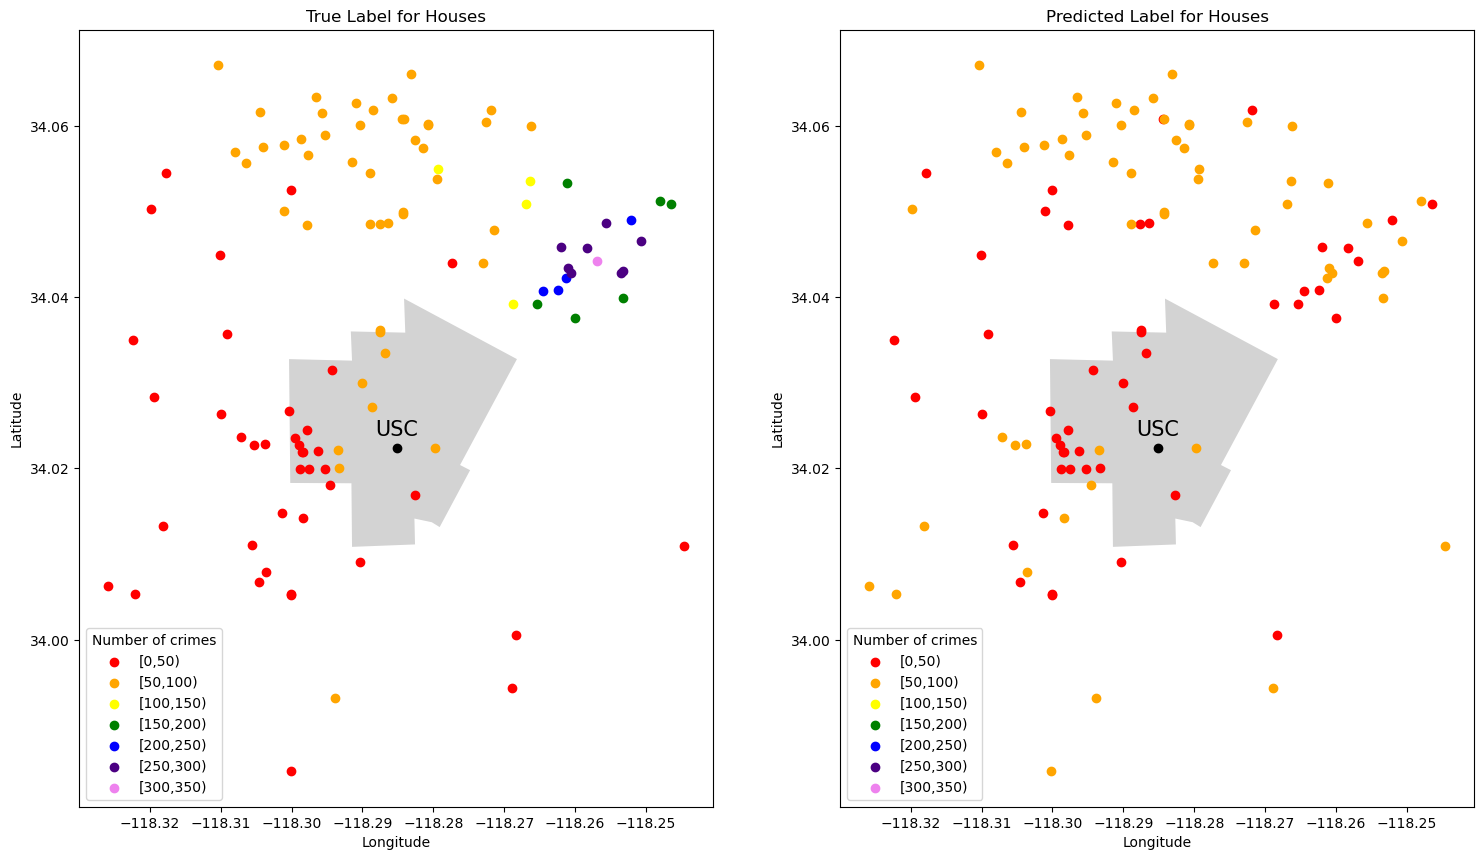

In [49]:
data=pd.read_csv('whole_dataset.csv')
y=data['Total']
X=data[['Distance(meter)','Longitude','Latitude','Price(in $)']]

y_values=[crime_num//50 for crime_num in y] # convert the numeric features to categorical
y=np.array(y_values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # randomly split the data set into training and test sets

# train the multi-layer perceptron classification model and calculate the accuracy rate on the test set.
MLPC=MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver='adam', activation='relu',random_state=0)
MLPC.fit(X_train,y_train)
y_pred=MLPC.predict(X_test)
print(f'For this multi-layer perceptron classification, the accuracy rate is {accuracy_score(y_test,y_pred)}.')
draw_classification(X_test,y_test,y_pred)

## 6. Research on Crime Types

Plot the houses with color noted as the most frequent crime type nearby each house.

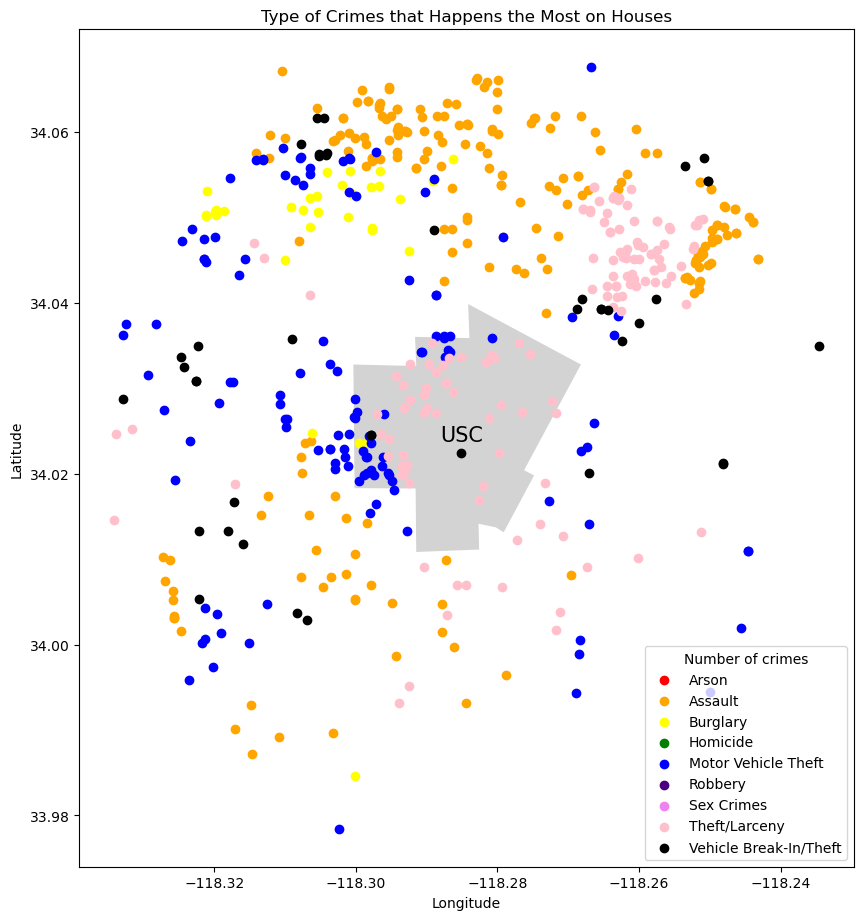

In [50]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])

# obtain the maximum crime type for each house
crimes=data.iloc[:,7:]
columns=list(crimes.columns)
type_indexes=[]
for index,row in crimes.iterrows():
    type_indexes.append(columns.index(row.idxmax()))

# Load the GeoJSON file into a GeoDataFrame
gdf_boundary = gpd.read_file('UPC_Patrol_Boundaries.geojson')

# store the latitude and longitude of a house together in a list
point_coords = [(long,lat) for lat,long in zip(lats,longs)]

# Convert the list of point coordinates into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[0] for coord in point_coords], 
                                                        [coord[1] for coord in point_coords]))

# define the color and its tag for each data point
colors=['red','orange','yellow','green','blue','indigo','violet','pink','black']
tags=columns

gdf_points['color'] = [colors[type_index] for type_index in type_indexes]
gdf_points['value'] = [tags[type_index] for type_index in type_indexes]

fig,ax=plt.subplots(figsize=(10, 50))
gdf_boundary.plot(ax=ax,color='lightgray') # plot the USC DPS zone
# plot each data point
for color,tag in zip(colors,tags):
    ax.scatter(gdf_points[gdf_points['color'] == color]['geometry'].x,
            gdf_points[gdf_points['color'] == color]['geometry'].y,
            color=color,
            label=tag)
ax.legend(title='Number of crimes')

# plot the position of USC
ax.scatter(-118.2851,34.0224, marker='o', color='black')
ax.text(-118.2851,34.0234, 'USC', ha='center', va='bottom', color='black',fontsize=15)

ax.set_title('Type of Crimes that Happens the Most on Houses')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Plot the pie chart and histogram for crime type.

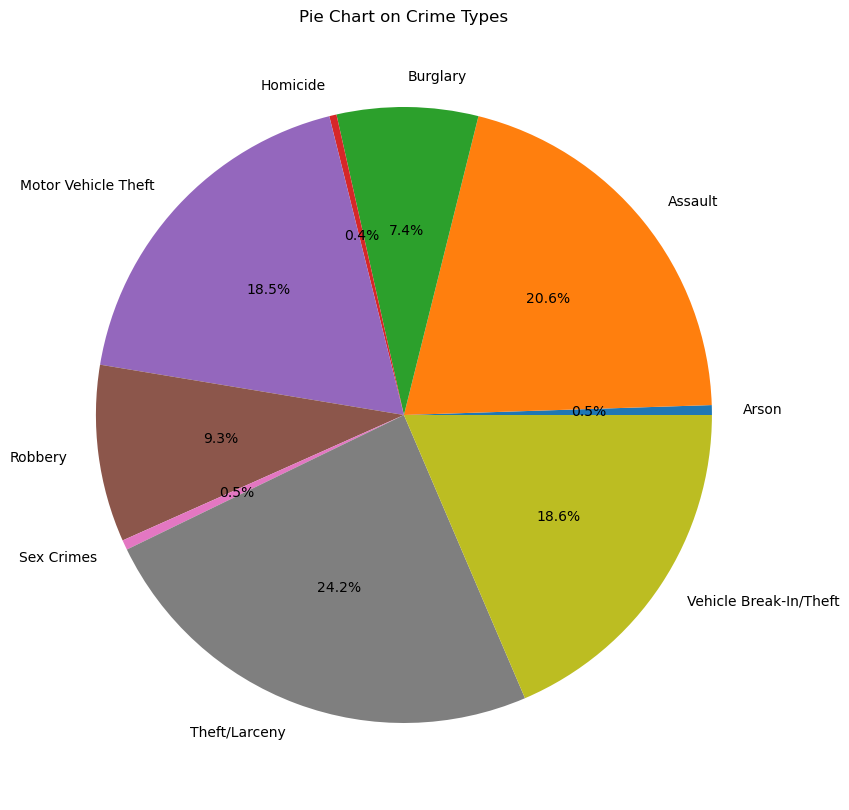

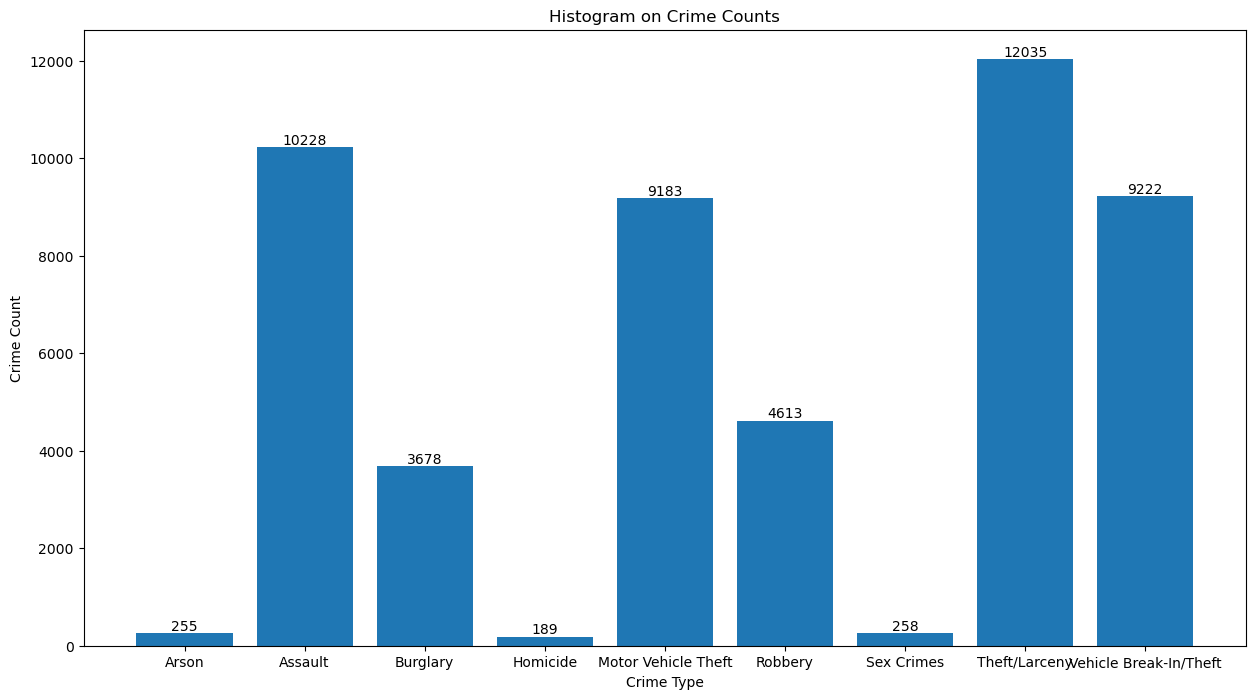

In [51]:
data=pd.read_csv('whole_dataset.csv')
lats=list(data['Latitude'])
longs=list(data['Longitude'])
totals=list(data['Total'])

crimes=data.iloc[:,7:]

# store the total number of each type of crime
type_total={}
for column in crimes.columns:
    type_total[column]=sum(crimes[column])

# plot the pie chart
plt.figure(figsize=(10,10))
plt.pie(type_total.values(), labels=type_total.keys(), autopct='%1.1f%%')
plt.title('Pie Chart on Crime Types')
plt.show()

# plot the histogram
plt.figure(figsize=(15,8))
plt.bar(type_total.keys(),type_total.values())
for i, count in enumerate(type_total.values()):
    plt.text(i, count+0.5, str(count), ha='center', va='bottom')
plt.title('Histogram on Crime Counts')
plt.xlabel('Crime Type')
plt.ylabel('Crime Count')
plt.show()
